In [2]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from alpha_vantage.cryptocurrencies import CryptoCurrencies

api_key = '36N2WM8I8W74IFZ0'

ts = CryptoCurrencies(key="api_key", output_format="pandas")
data, meta_data= ts.get_digital_currency_daily(symbol='BTC', market = 'USD')
data = data.reindex(index=data.index[::-1])
print(data)

            1a. open (USD)  1b. open (USD)  2a. high (USD)  2b. high (USD)  \
date                                                                         
2018-09-01         7011.21         7011.21         7275.00         7275.00   
2018-09-02         7201.57         7201.57         7345.45         7345.45   
2018-09-03         7302.00         7302.00         7338.28         7338.28   
2018-09-04         7263.00         7263.00         7410.00         7410.00   
2018-09-05         7359.05         7359.05         7397.30         7397.30   
...                    ...             ...             ...             ...   
2021-05-23        37458.51        37458.51        38270.64        38270.64   
2021-05-24        34681.44        34681.44        39920.00        39920.00   
2021-05-25        38810.99        38810.99        39791.77        39791.77   
2021-05-26        38324.72        38324.72        40841.00        40841.00   
2021-05-27        39241.92        39241.92        39243.10      

In [3]:
close_data = data['4a. close (USD)']
print (close_data)

date
2018-09-01     7200.01
2018-09-02     7302.01
2018-09-03     7263.02
2018-09-04     7359.06
2018-09-05     6700.00
                ...   
2021-05-23    34655.25
2021-05-24    38796.29
2021-05-25    38324.72
2021-05-26    39241.91
2021-05-27    38538.41
Name: 4a. close (USD), Length: 1000, dtype: float64


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))

In [5]:
prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
29/29 [==============================] - 8s 112ms/step - loss: 0.0269
Epoch 2/25
29/29 [==============================] - 3s 113ms/step - loss: 0.0029
Epoch 3/25
29/29 [==============================] - 3s 109ms/step - loss: 0.0029
Epoch 4/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0023
Epoch 5/25
29/29 [==============================] - 3s 107ms/step - loss: 0.0026
Epoch 6/25
29/29 [==============================] - 3s 109ms/step - loss: 0.0022
Epoch 7/25
29/29 [==============================] - 3s 109ms/step - loss: 0.0017
Epoch 8/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0018
Epoch 9/25
29/29 [==============================] - 3s 116ms/step - loss: 0.0019
Epoch 10/25
29/29 [==============================] - 3s 112ms/step - loss: 0.0015
Epoch 11/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0016
Epoch 12/25
29/29 [==============================] - 3s 116ms/step - loss: 0.0019
Epoch 13/25
29/29 [======

In [8]:
predicted_prices = model.predict(x_train)
predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = data['4a. close (USD)'].values

for x in range(0, prediction_days+1):
    actual_prices = np.delete(actual_prices, 0)

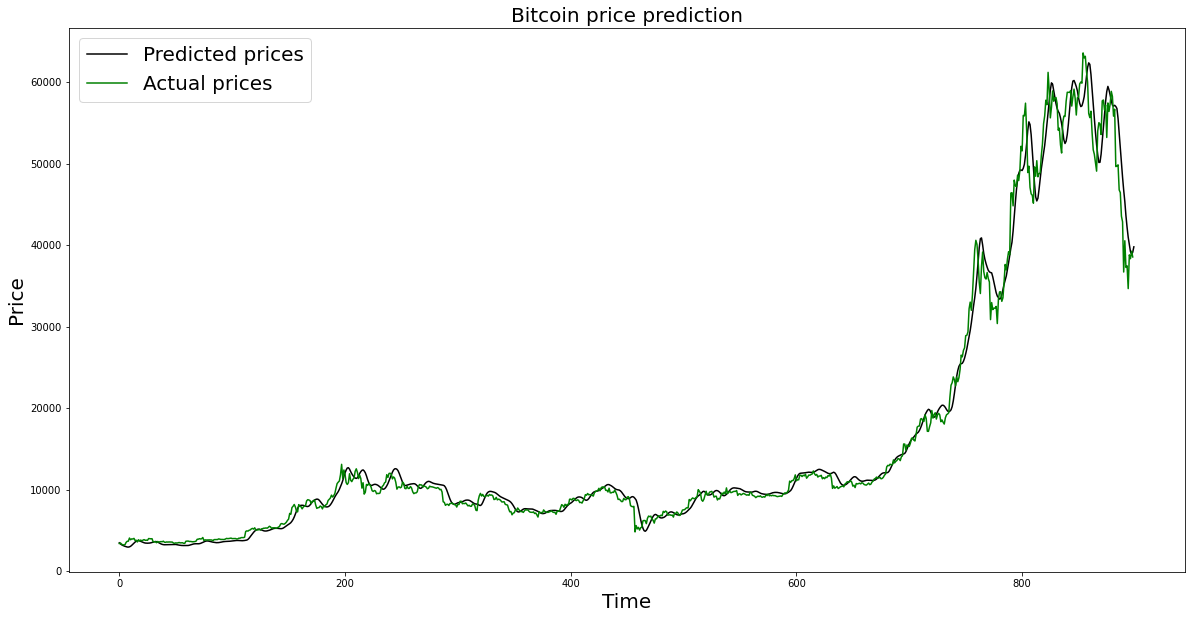

In [9]:
plt.figure(figsize=(20,10))
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_prices, color="green", label="Actual prices")
plt.title(f'Bitcoin price prediction', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()